 URL: https://pytorch.org/tutorials/intermediate/char_rnn_classification_tutorial.html

結論: 単語や文字をOne-hot-vectorにして、予測させる  
回帰問題として解くには、最後の入力時のoutput_vectorを多クラス分類結果として使用  
これ単体では、(1, アルファベット)のベクトル化しか出来ない  

単語を意味のあるベクトル化するには、別の工夫を施さないといけない

In [49]:
# GPUで計算させるには
# model.to(device)
# tensor(device=device)
# として、modelとtensor_dataをGPUに転送する必要がある
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
from io import open
import glob
import os

def findFiles(path): return glob.glob(path)

print(findFiles('../input/names/*.txt'))

import unicodedata
import string

all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

# Turn a Unicode string to plain ASCII,
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

print(unicodeToAscii('Ślusàrski'))

# Build the category_lines dictionary, a list of names per language
category_lines = {}
all_categories = []

# Read a file and split into lines
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

for filename in findFiles('../input/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines
    
n_categories = len(all_categories)

['../input/names/Japanese.txt', '../input/names/Czech.txt', '../input/names/Arabic.txt', '../input/names/Irish.txt', '../input/names/German.txt', '../input/names/Portuguese.txt', '../input/names/French.txt', '../input/names/Dutch.txt', '../input/names/Russian.txt', '../input/names/Polish.txt', '../input/names/Vietnamese.txt', '../input/names/Greek.txt', '../input/names/Spanish.txt', '../input/names/Scottish.txt', '../input/names/Korean.txt', '../input/names/Chinese.txt', '../input/names/Italian.txt', '../input/names/English.txt']
Slusarski


category_lines: keyが国、valueが人名のlist  
all_categories: 国名が入ったlist  
n_categories: 国名の種類  

all_letters: 使用されている全ての文字が格納されたlist

Turning Names into Tensors

In [50]:
import torch

# Find letter index from all_letters, e.g. "a" = 0
def letterToIndex(letter):
    # all_letters(list)の中から、該当する文字があるindex(int)を返す
    return all_letters.find(letter)

# Just for demonstration, turn a letter into a <1 x n_letters> Tensor
def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters, device=device)
    tensor[0][letterToIndex(letter)] = 1
    return tensor

# Turn a line into a <line_length x 1 x n_letters>
# or an array of one-hot letter vectors
def lineToTensor(line):
    # 名前のアルファベットを入力すると
    # <名前の長さ x 1 x len(all_letters)>という、
    # One-hot-vectorを結合したTensorを返す
    tensor = torch.zeros(len(line), 1, n_letters, device=device)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

print(letterToTensor('J'))

print(lineToTensor('Jones').size())

tensor([[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]], device='cuda:0')
torch.Size([5, 1, 57])


In [56]:
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        
        self.hidden_size = hidden_size
        
        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        # output_size: 存在する国の数, 各国の所属確率のOne-hot-vectorを返す
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)
        
    def forward(self, input, hidden):
        # input: (1, 1, input_size)
        # hidden: (1, 1, hidden_size)
        # combined: (1, 1, input_size+hidden_size)
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden
    
    def initHidden(self):
        return torch.zeros(1, self.hidden_size, device=device)
    
n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_categories).to(device)

Function check

In [59]:
input = letterToTensor('A')
hidden = torch.zeros(1, n_hidden, device=device)

output, next_input = rnn(input, hidden)

In [62]:
input = lineToTensor('Albert')
hidden = torch.zeros(1, n_hidden, device=device)

output, next_hidden = rnn(input[0], hidden)
print(output)
print(output.shape)
print(next_hidden.shape)

tensor([[-2.8603, -2.9987, -2.8557, -2.9675, -2.8195, -2.8202, -2.8534,
         -2.9124, -2.9258, -2.8385, -2.9626, -3.0032, -2.8230, -2.8307,
         -2.8815, -2.8136, -2.9445, -2.9525]], device='cuda:0')
torch.Size([1, 18])
torch.Size([1, 128])


Preparing for Training

In [88]:
def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    # top_i: 最も所属確率の高い国のindex(Tensor)
    # category_i: index(int)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i

print(categoryFromOutput(output))

('Chinese', 15)


training example

In [93]:
import random

def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingExample():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long, device=device)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor

for i in range(10):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    print('category =', category, '\line = ', line)

category = Polish \line =  Adamczak
category = Czech \line =  Chromy
category = Dutch \line =  Rooiakkers
category = Greek \line =  Dounias
category = Greek \line =  Kouretas
category = Irish \line =  Coilean
category = Irish \line =  Doherty
category = German \line =  Voigts
category = German \line =  Blau
category = Portuguese \line =  Gomes


Training the Network

In [94]:
criterion = nn.NLLLoss()

In [95]:
learning_rate = 0.005

def train(category_tensor, line_tensor):
    hidden = rnn.initHidden()
    
    rnn.zero_grad()
    
    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)
    
    loss = criterion(output, category_tensor)
    loss.backward()
    
    # Add parameters' gradients to their values, multiplied by learning rate
    # ここでは手動でパラメータの誤差を格納している
    # parameterをadd_すると、次のstepで使用するparamが更新されると思う
    # optimizerを使う場合は、optim.step()を書く
    # learning_rateとp.grad.dataを掛け算する
    # 勾配(誤差)は減算するので、-1をlearning_rateに掛ける
    for p in rnn.parameters():
        p.data.add_(-learning_rate, p.grad.data)
        
    return output, loss.item()

In [96]:
import time
import math

n_iters = 100000
print_every = 5000
plot_every = 1000

# Keep track of losses for plotting
current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters + 1):
    # ランダムに学習データを選択
    category, line, category_tensor, line_tensor = randomTrainingExample()
    # 学習、loss(real)を出力
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss
    
    # Print iter number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (
            iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))
        
    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

5000 5% (0m 18s) 2.5499 Beloded / Spanish ✗ (Russian)
10000 10% (0m 37s) 2.1676 Grenard / Italian ✗ (English)
15000 15% (0m 56s) 1.5830 Ruvelas / Greek ✓
20000 20% (1m 16s) 1.0012 Lolos / Greek ✓
25000 25% (1m 35s) 1.2894 Jiu / Korean ✗ (Chinese)
30000 30% (1m 54s) 3.5403 Baisaroff / Japanese ✗ (Russian)
35000 35% (2m 13s) 1.6705 Mohren / Dutch ✓
40000 40% (2m 30s) 0.6458 Gan / Chinese ✓
45000 45% (2m 49s) 1.3450 Ton / Korean ✗ (Vietnamese)
50000 50% (3m 7s) 3.0014 Fraser / German ✗ (Scottish)
55000 55% (3m 25s) 0.8491 Kuai / Chinese ✓
60000 60% (3m 45s) 2.4942 StrakaO / Polish ✗ (Czech)
65000 65% (4m 5s) 1.5337 Hadjiyianakies / Japanese ✗ (Greek)
70000 70% (4m 23s) 0.5600 Sawamatsu / Japanese ✓
75000 75% (4m 42s) 1.3979 Valeev / Spanish ✗ (Russian)
80000 80% (5m 0s) 3.1520 Park  / Russian ✗ (Korean)
85000 85% (5m 18s) 1.2135 Loyola / Spanish ✓
90000 90% (5m 36s) 2.5962 Skala / Spanish ✗ (Polish)
95000 95% (5m 55s) 2.2926 Safko / Polish ✗ (Czech)
100000 100% (6m 14s) 1.6113 Chung / Vie

CPUで計算した場合、5分28秒かかった  
GPUで計算した場合、6分14秒かかった  
計算が少量だったり、巨大な行列計算をしない場合は、CPUの方が速い

Plotting the results

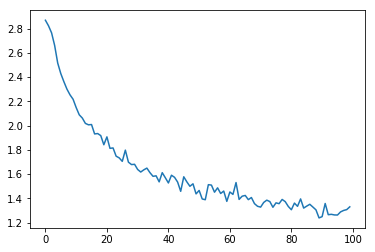

In [97]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)

Evaluating the results

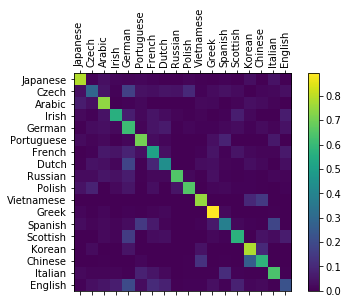

In [102]:
# Keep track of correct guesses in a confusion matrix
confusion = torch.zeros(n_categories, n_categories, device=device)
n_confusion = 10000

# Just return an output given a line
# 最終層の出力(1, 国数)さえ手に入れば良い
# 最終層の出力は、1文字ずつ名前を入力した人がどこの国の人かを表すOne-hot-vector
def evaluate(line_tensor):
    hidden = rnn.initHidden()
    
    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)
    
    return output

# Go through a bunch of examples and record which are correctly guessed
for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output = evaluate(line_tensor)
    guess, guess_i = categoryFromOutput(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1
    
# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()
    
# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.cpu().numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([' '] + all_categories, rotation=90)
ax.set_yticklabels([' '] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

In [109]:
def predict(input_line, n_predictions=3):
    print('\n> %s' % input_line)
    with torch.no_grad():
        output = evaluate(lineToTensor(input_line))
        
        # Get top N categories
        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []
        
        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print('(%.2f) %s' % (value, all_categories[category_index]))
            predictions.append([value, all_categories[category_index]])

In [110]:
predict('Dovesky')


> Dovesky
(-0.41) Russian
(-1.47) Czech
(-3.02) English


In [111]:
predict('Uchide')


> Uchide
(-1.12) German
(-1.51) French
(-1.74) English


In [117]:
predict('Sato')


> Sato
(-1.73) Korean
(-1.80) Japanese
(-1.89) Portuguese
